# PTML - Supervised - Heart Failure Prediction dataset

Our goal is to predict whether someone has a heart Disease based on some of their vitals.

Link: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

Attribute Information
 - Age: age of the patient [years]
 - Sex: sex of the patient [M: Male, F: Female]
 - ChestPainType: chest pain type \[TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
 - RestingBP: resting blood pressure [mm Hg]
 - Cholesterol: serum cholesterol [mm/dl]
 - FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
 - RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
 - MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
 - ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
 - Oldpeak: oldpeak = ST [Numeric value measured in depression]
 - ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
 - HeartDisease: output class [1: heart disease, 0: Normal]

In [1]:
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix

plt.rcParams['figure.figsize'] = (16,9)

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Load the Dataset

In [2]:
df = pd.read_csv('../data/supervised/heart.csv')

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
h, w = df.shape
print(f'The data has {h} rows and {w} columns')

The data has 918 rows and 12 columns


## Data Exploration

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


There are 6 uint64 colums, 5 object columns and 1 float64 column

## Missing Data

In [6]:
df.isna().sum().sort_values(ascending =False)

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [7]:
df[df.Cholesterol == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


We notice that we have a 172 missing Cholesterol reading. Furthermore those values seem very strange since we jump from 0 to a 100 for the next entries. Although this is a pretty significant number of missing data, we will use mean to estimate those values

In [8]:
df = df[df['Cholesterol'] != 0]

We scrapped the Cholesterol values because they were really imputing the quality of the results

## Summary Statistics

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,746.0,52.882038,9.505888,28.0,46.00,54.0,59.0,77.0
RestingBP,746.0,133.022788,17.282750,92.0,120.00,130.0,140.0,200.0
Cholesterol,746.0,244.635389,59.153524,85.0,207.25,237.0,275.0,603.0
FastingBS,746.0,0.167560,0.373726,0.0,0.00,0.0,0.0,1.0
MaxHR,746.0,140.226542,24.524107,69.0,122.00,140.0,160.0,202.0
Oldpeak,746.0,0.901609,1.072861,-0.1,0.00,0.5,1.5,6.2
HeartDisease,746.0,0.477212,0.499816,0.0,0.00,0.0,1.0,1.0


In [10]:
df[df.RestingBP == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease


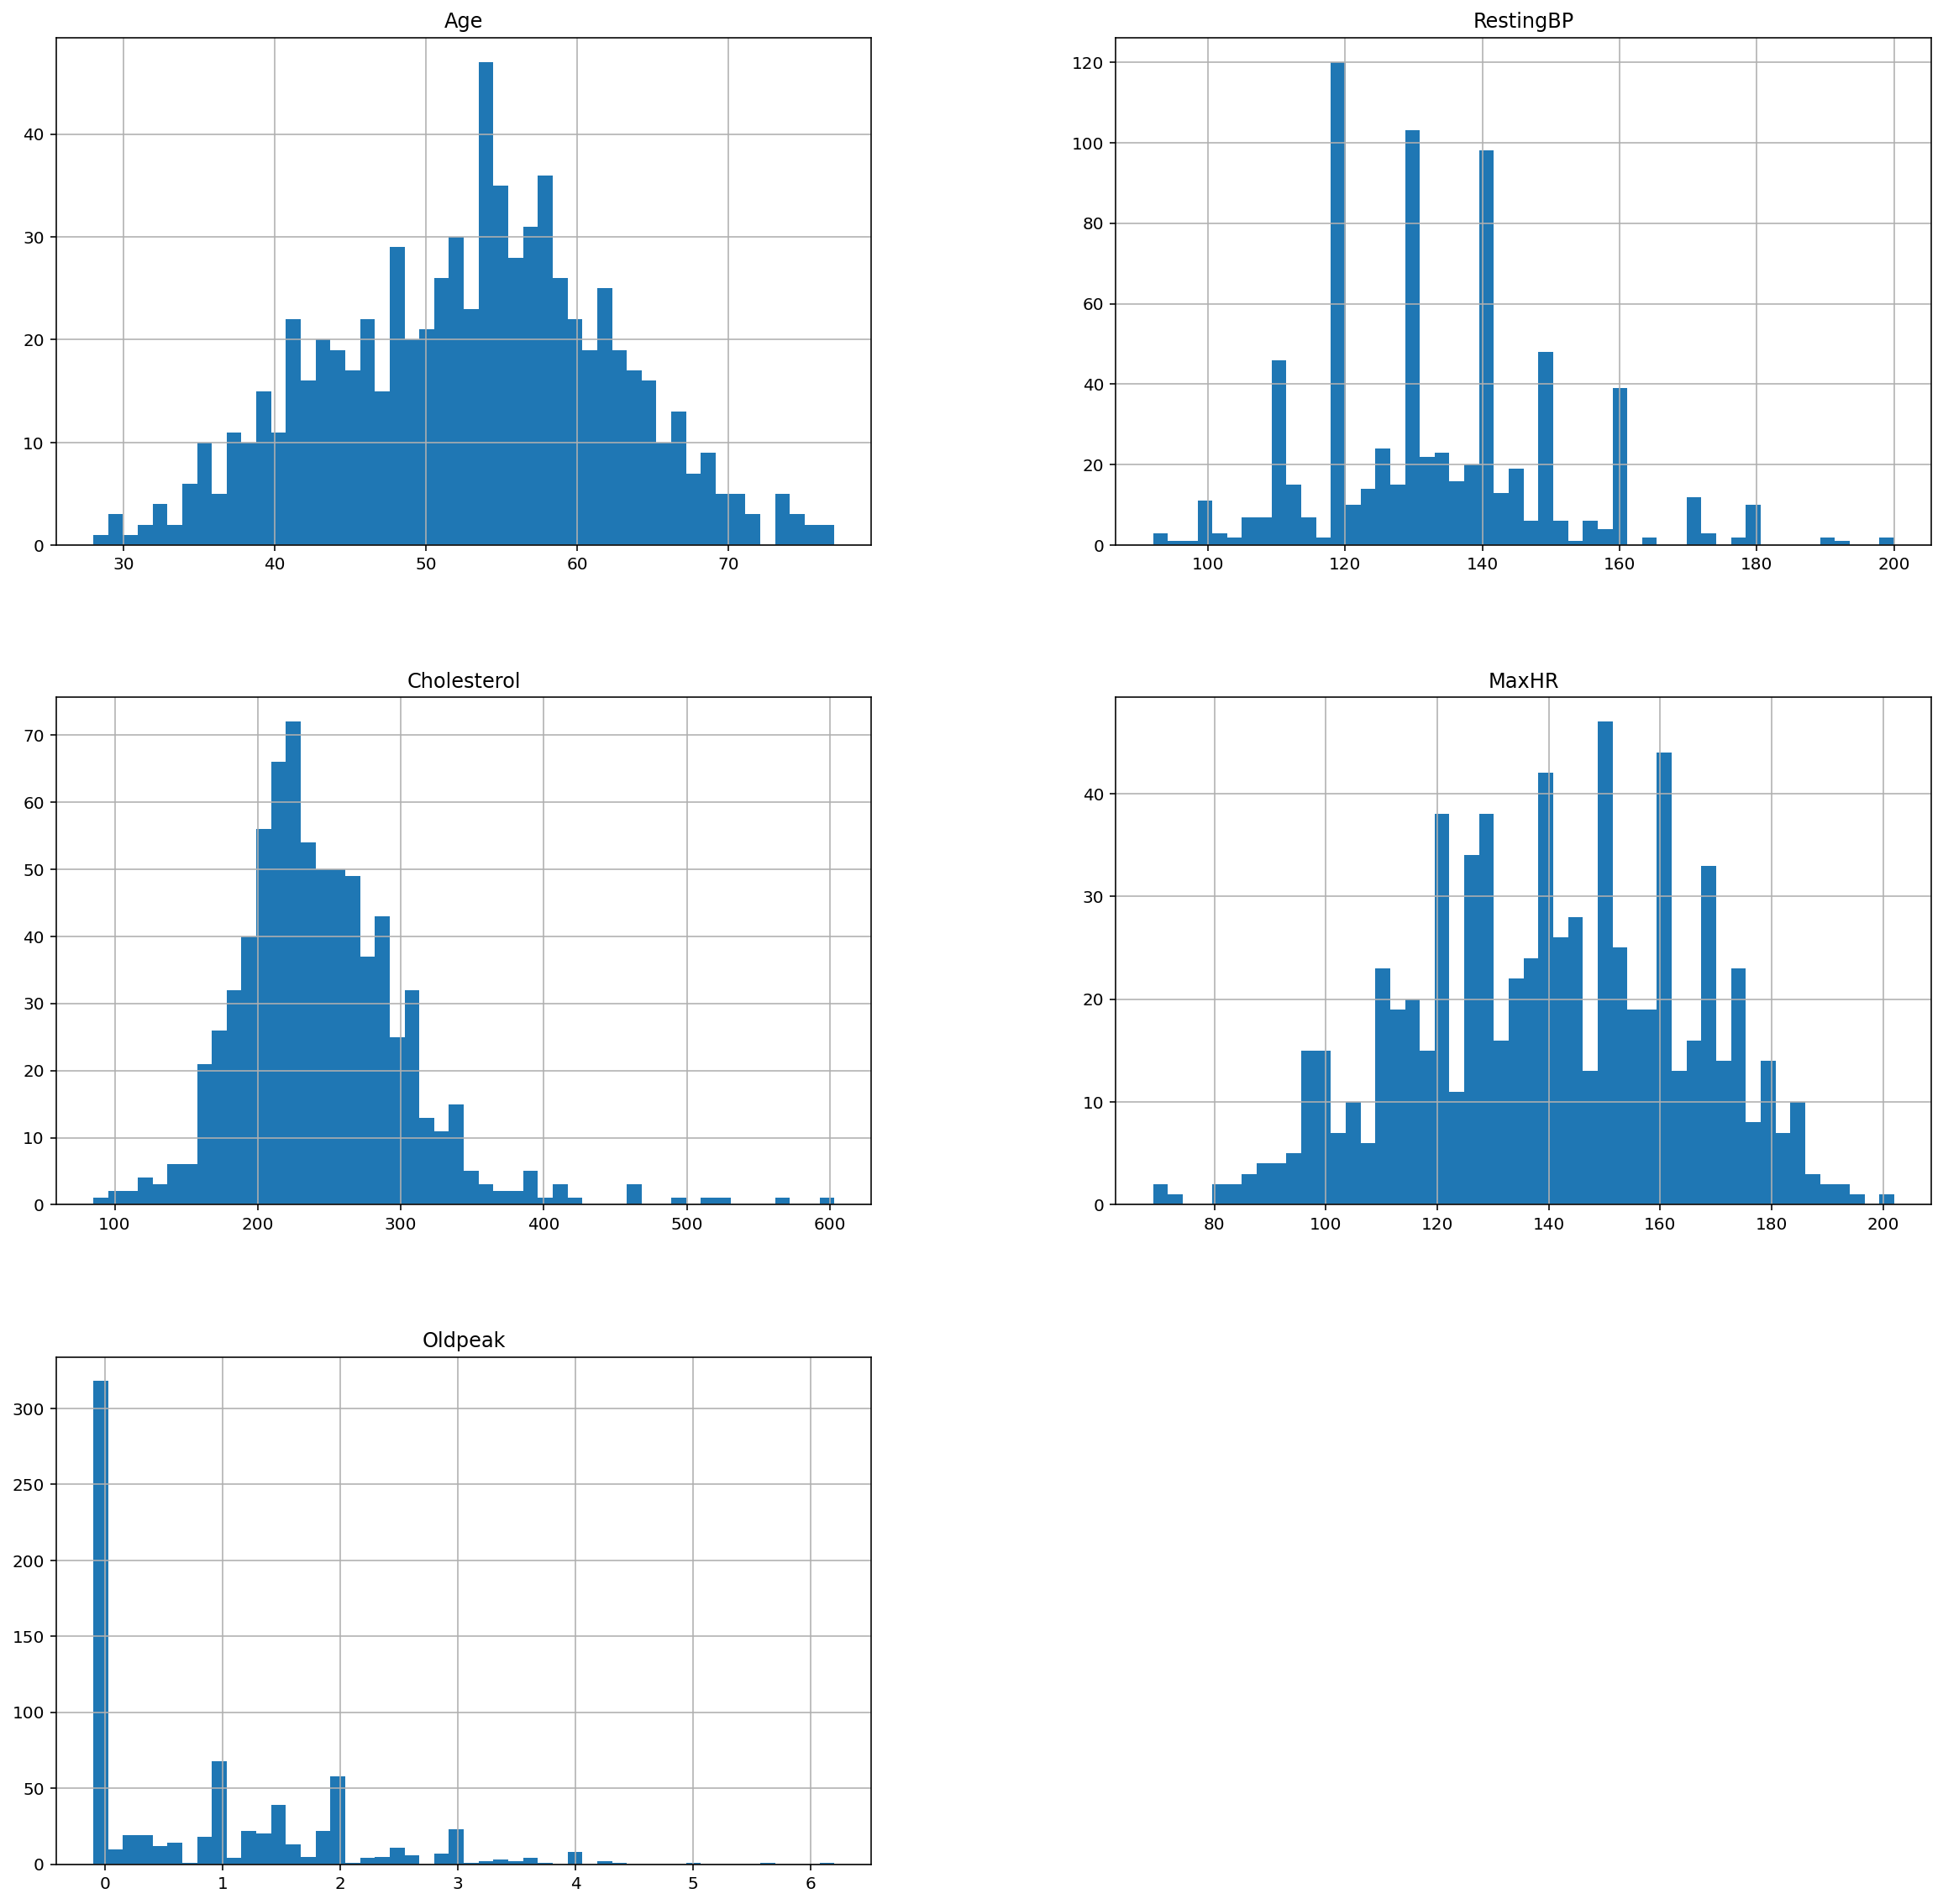

In [11]:
# Plot the histogram of each non-categorial attribute
df.hist(column = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'],bins=50, figsize=(20, 20))
plt.show()

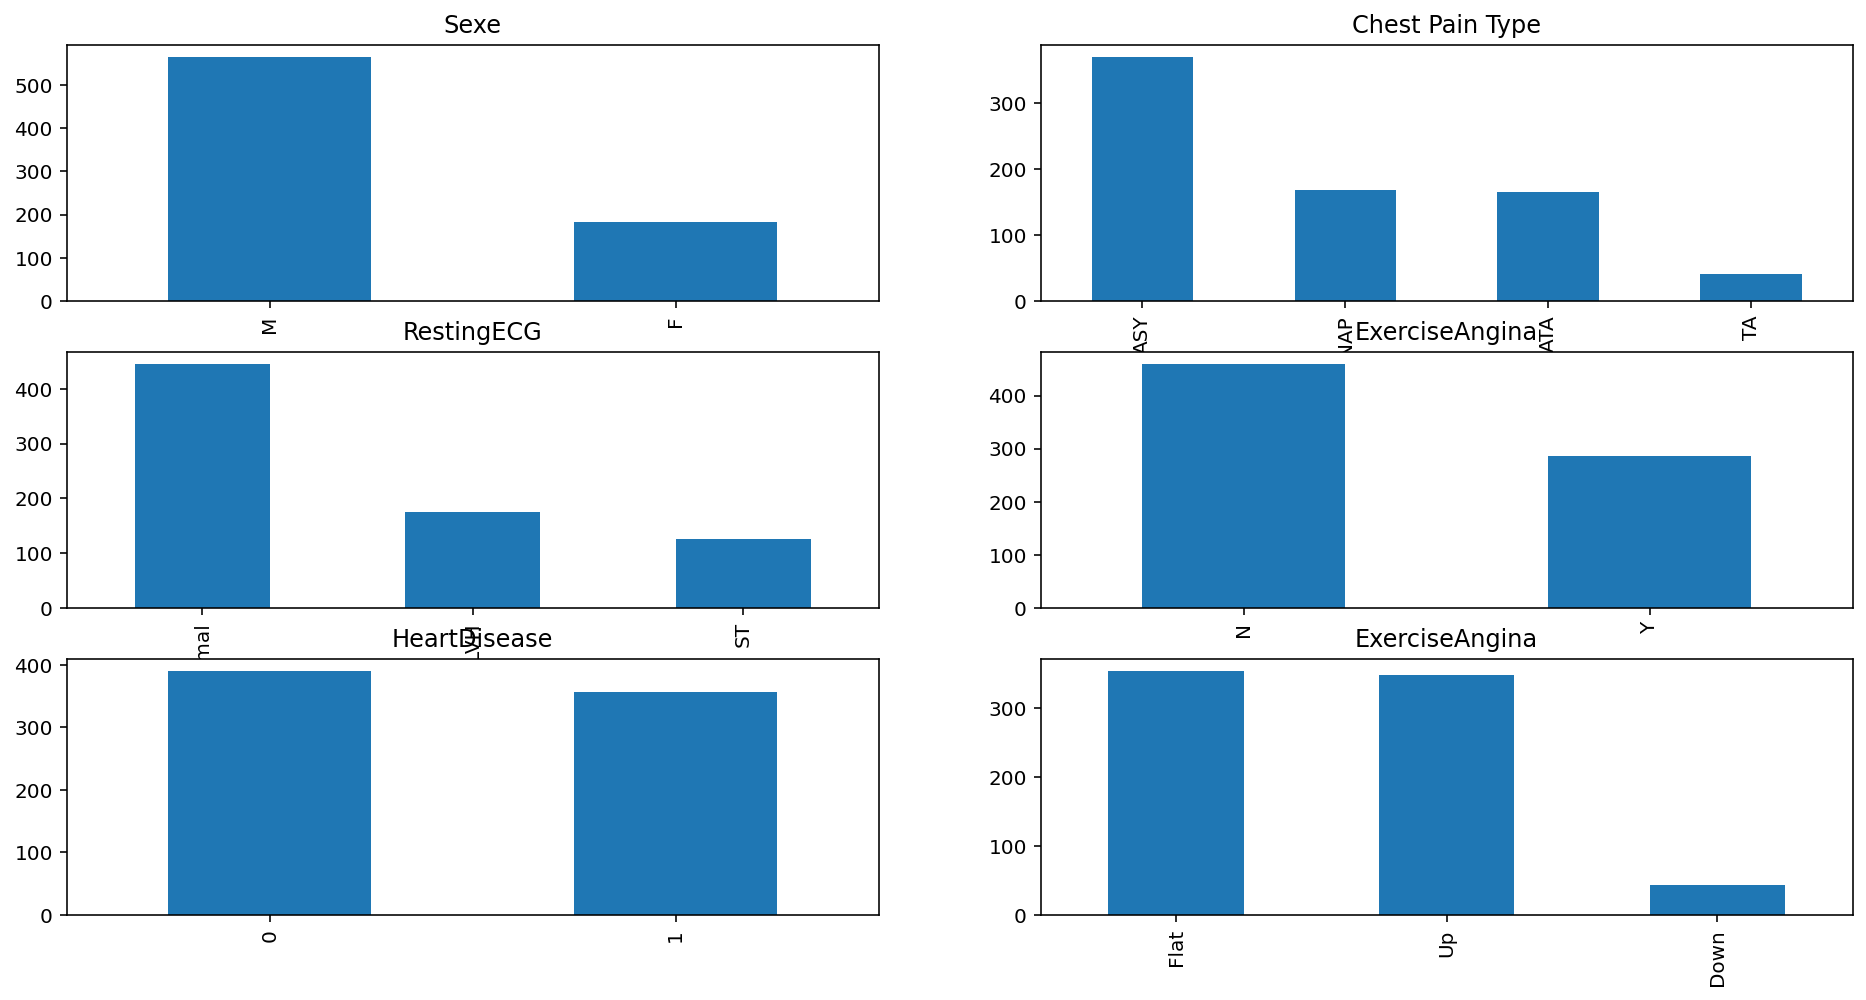

In [16]:
# Plot the histogram of each categorical attribute
fig, axs = plt.subplots(3, 2, figsize=(16, 8))

df['Sex'].value_counts().plot(kind='bar', ax=axs[0, 0], title = "Sexe")
df['ChestPainType'].value_counts().plot(kind='bar', ax=axs[0, 1], title = "Chest Pain Type")

df['RestingECG'].value_counts().plot(kind='bar', ax=axs[1, 0], title = "RestingECG")
df['ExerciseAngina'].value_counts().plot(kind='bar', ax=axs[1, 1], title = "ExerciseAngina")

df['ST_Slope'].value_counts().plot(kind='bar', ax=axs[2, 1], title = "ExerciseAngina")
df['HeartDisease'].value_counts().plot(kind='bar', ax=axs[2, 0], title = "HeartDisease")

plt.show()

We can see the repartition of each attributes.

## Features Engineering

### Remove outliers

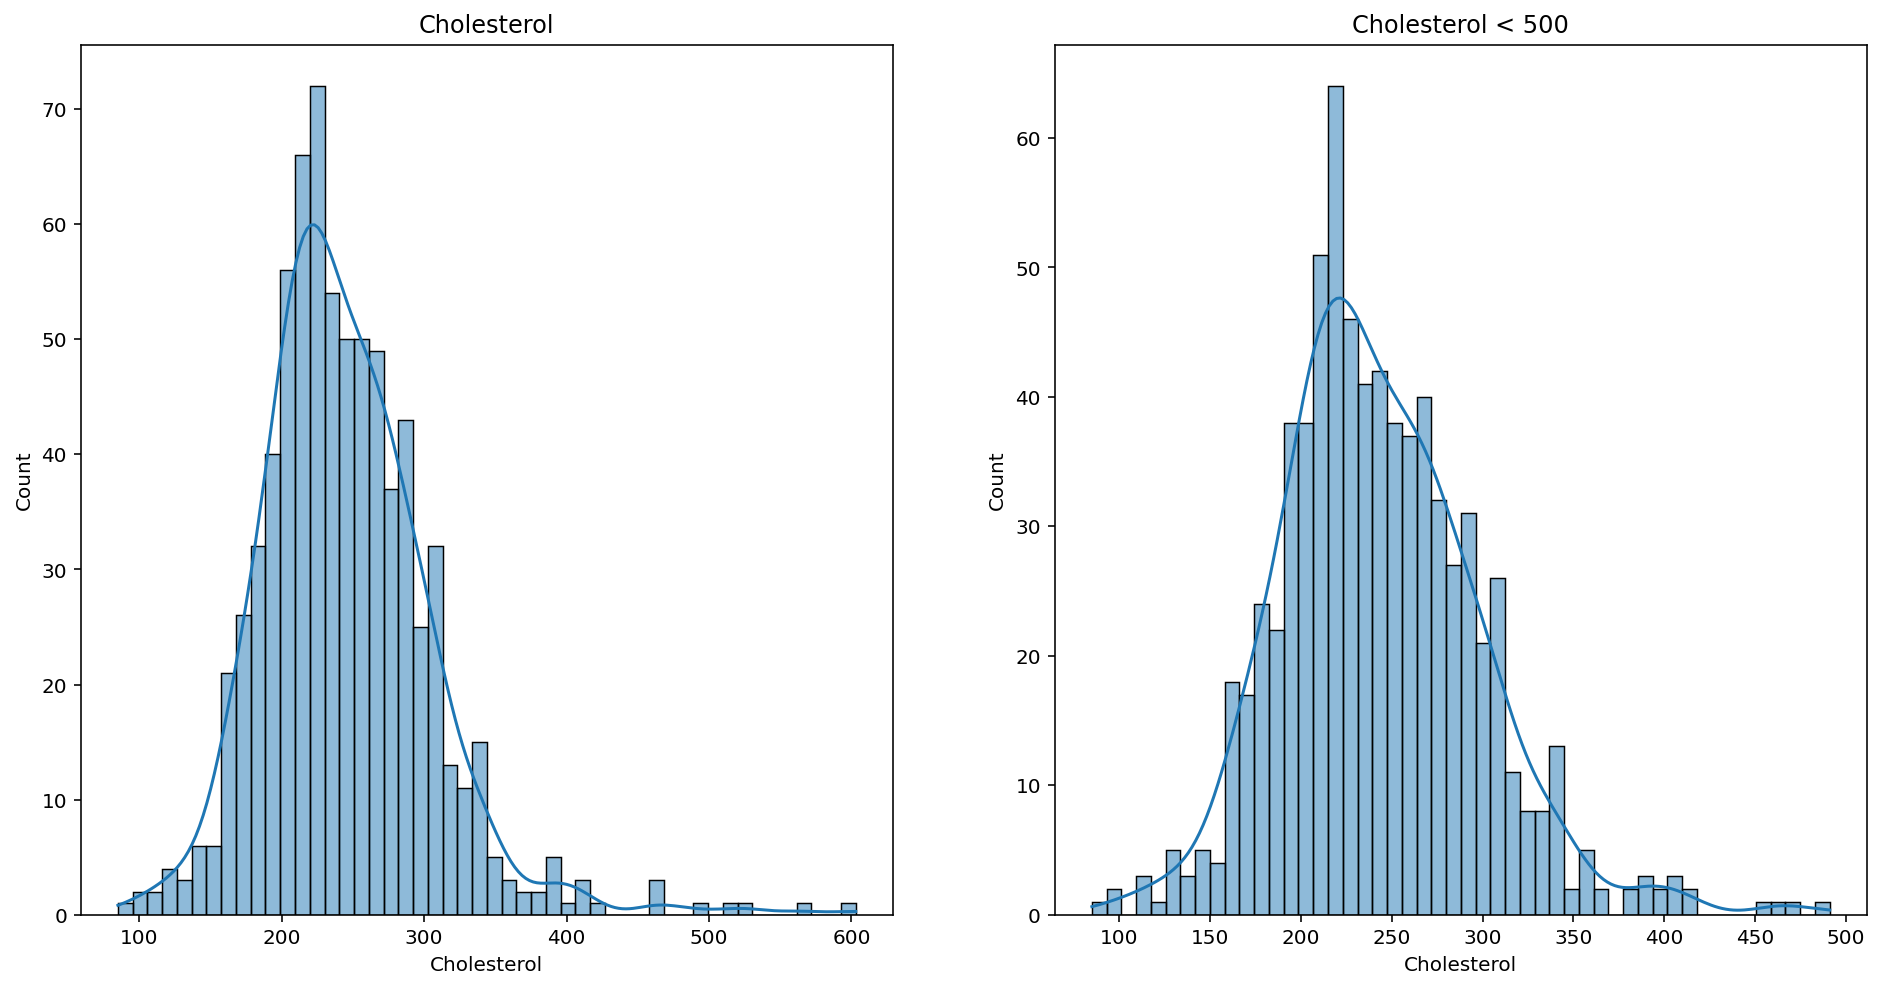

In [13]:
# Plot the histogram of the "Age" attribute
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

sn.histplot(data=df, x="Cholesterol", kde=True, bins=50, ax=axs[0])
sn.histplot(data=df[df["Cholesterol"] < 500], x="Cholesterol", kde=True, bins=50, ax=axs[1])

axs[0].set_title("Cholesterol")
axs[1].set_title("Cholesterol < 500")
plt.show()

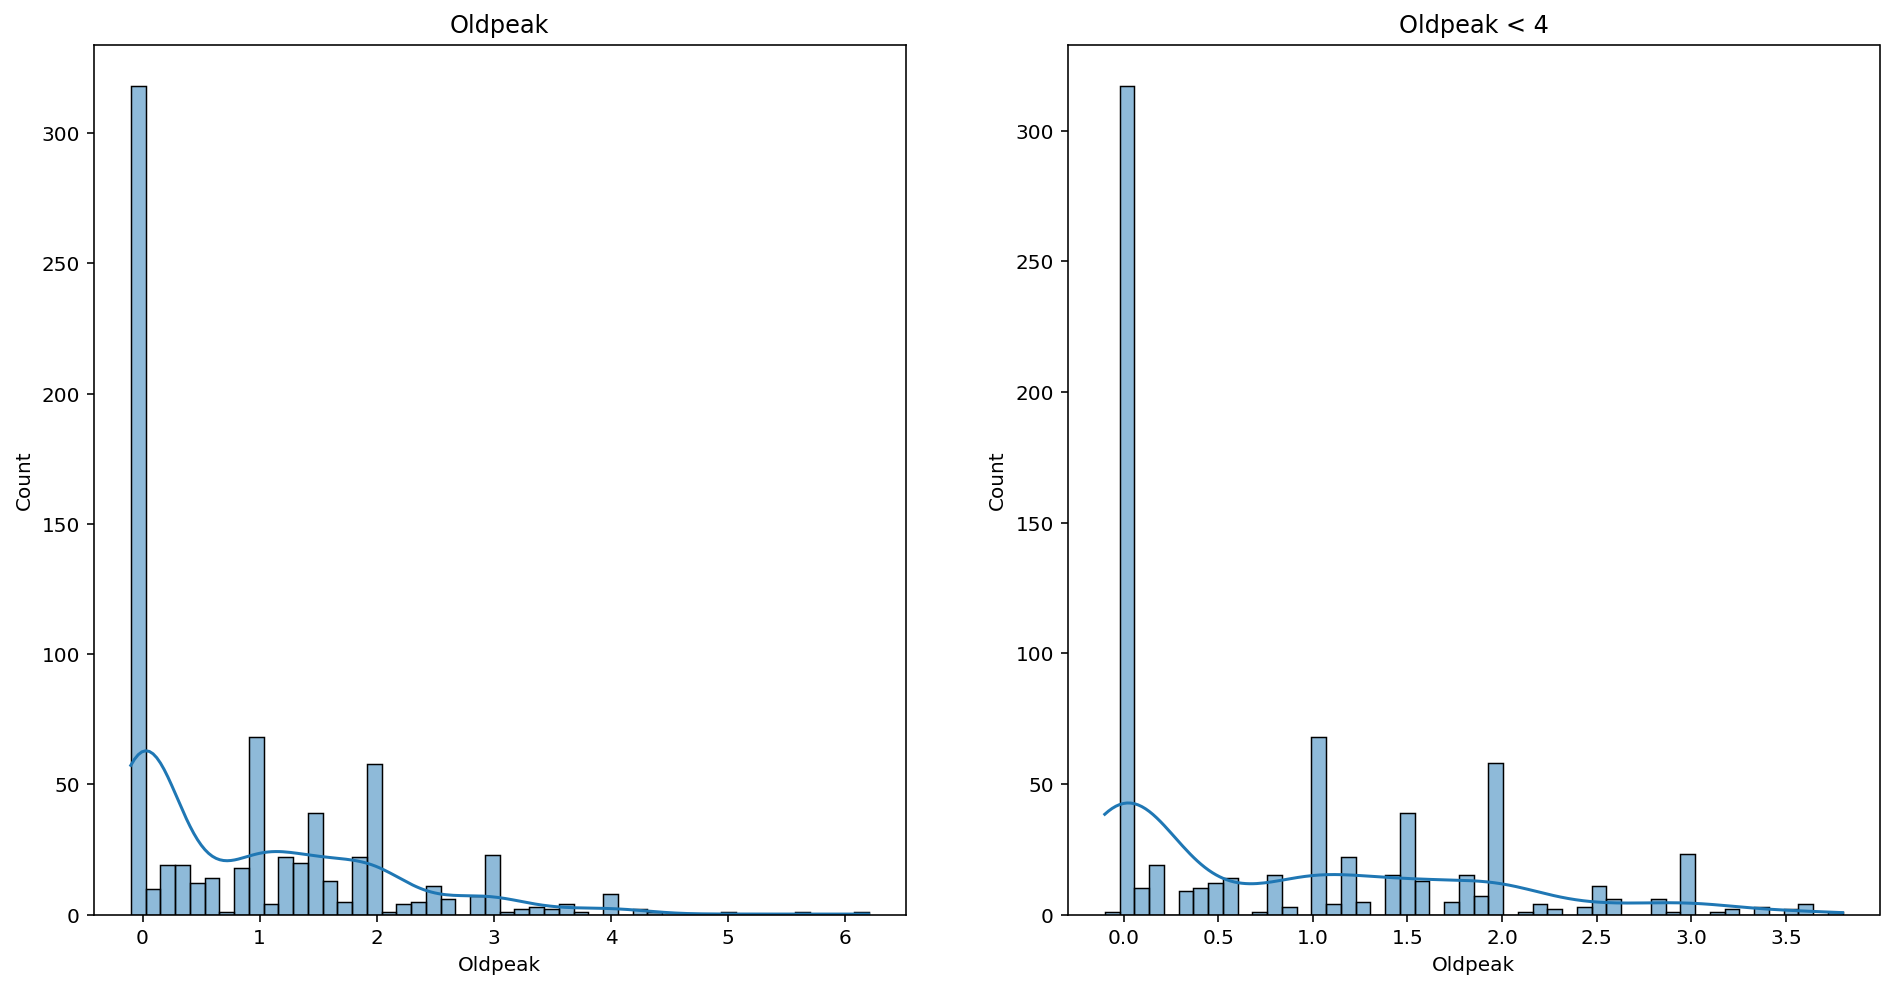

In [18]:
# Plot the histogram of the "Age" attribute
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

sn.histplot(data=df, x="Oldpeak", kde=True, bins=50, ax=axs[0])
sn.histplot(data=df[df["Oldpeak"] < 4], x="Oldpeak", kde=True, bins=50, ax=axs[1])

axs[0].set_title("Oldpeak")
axs[1].set_title("Oldpeak < 4")

plt.show()

In [24]:
print(df[df["Oldpeak"] < 4].size/df.size)
print(df[df["Cholesterol"] < 500].size/df.size)

df = df[df["Oldpeak"] < 4]
df = df[df["Cholesterol"] < 500]

1.0
1.0


### Correlation matrix

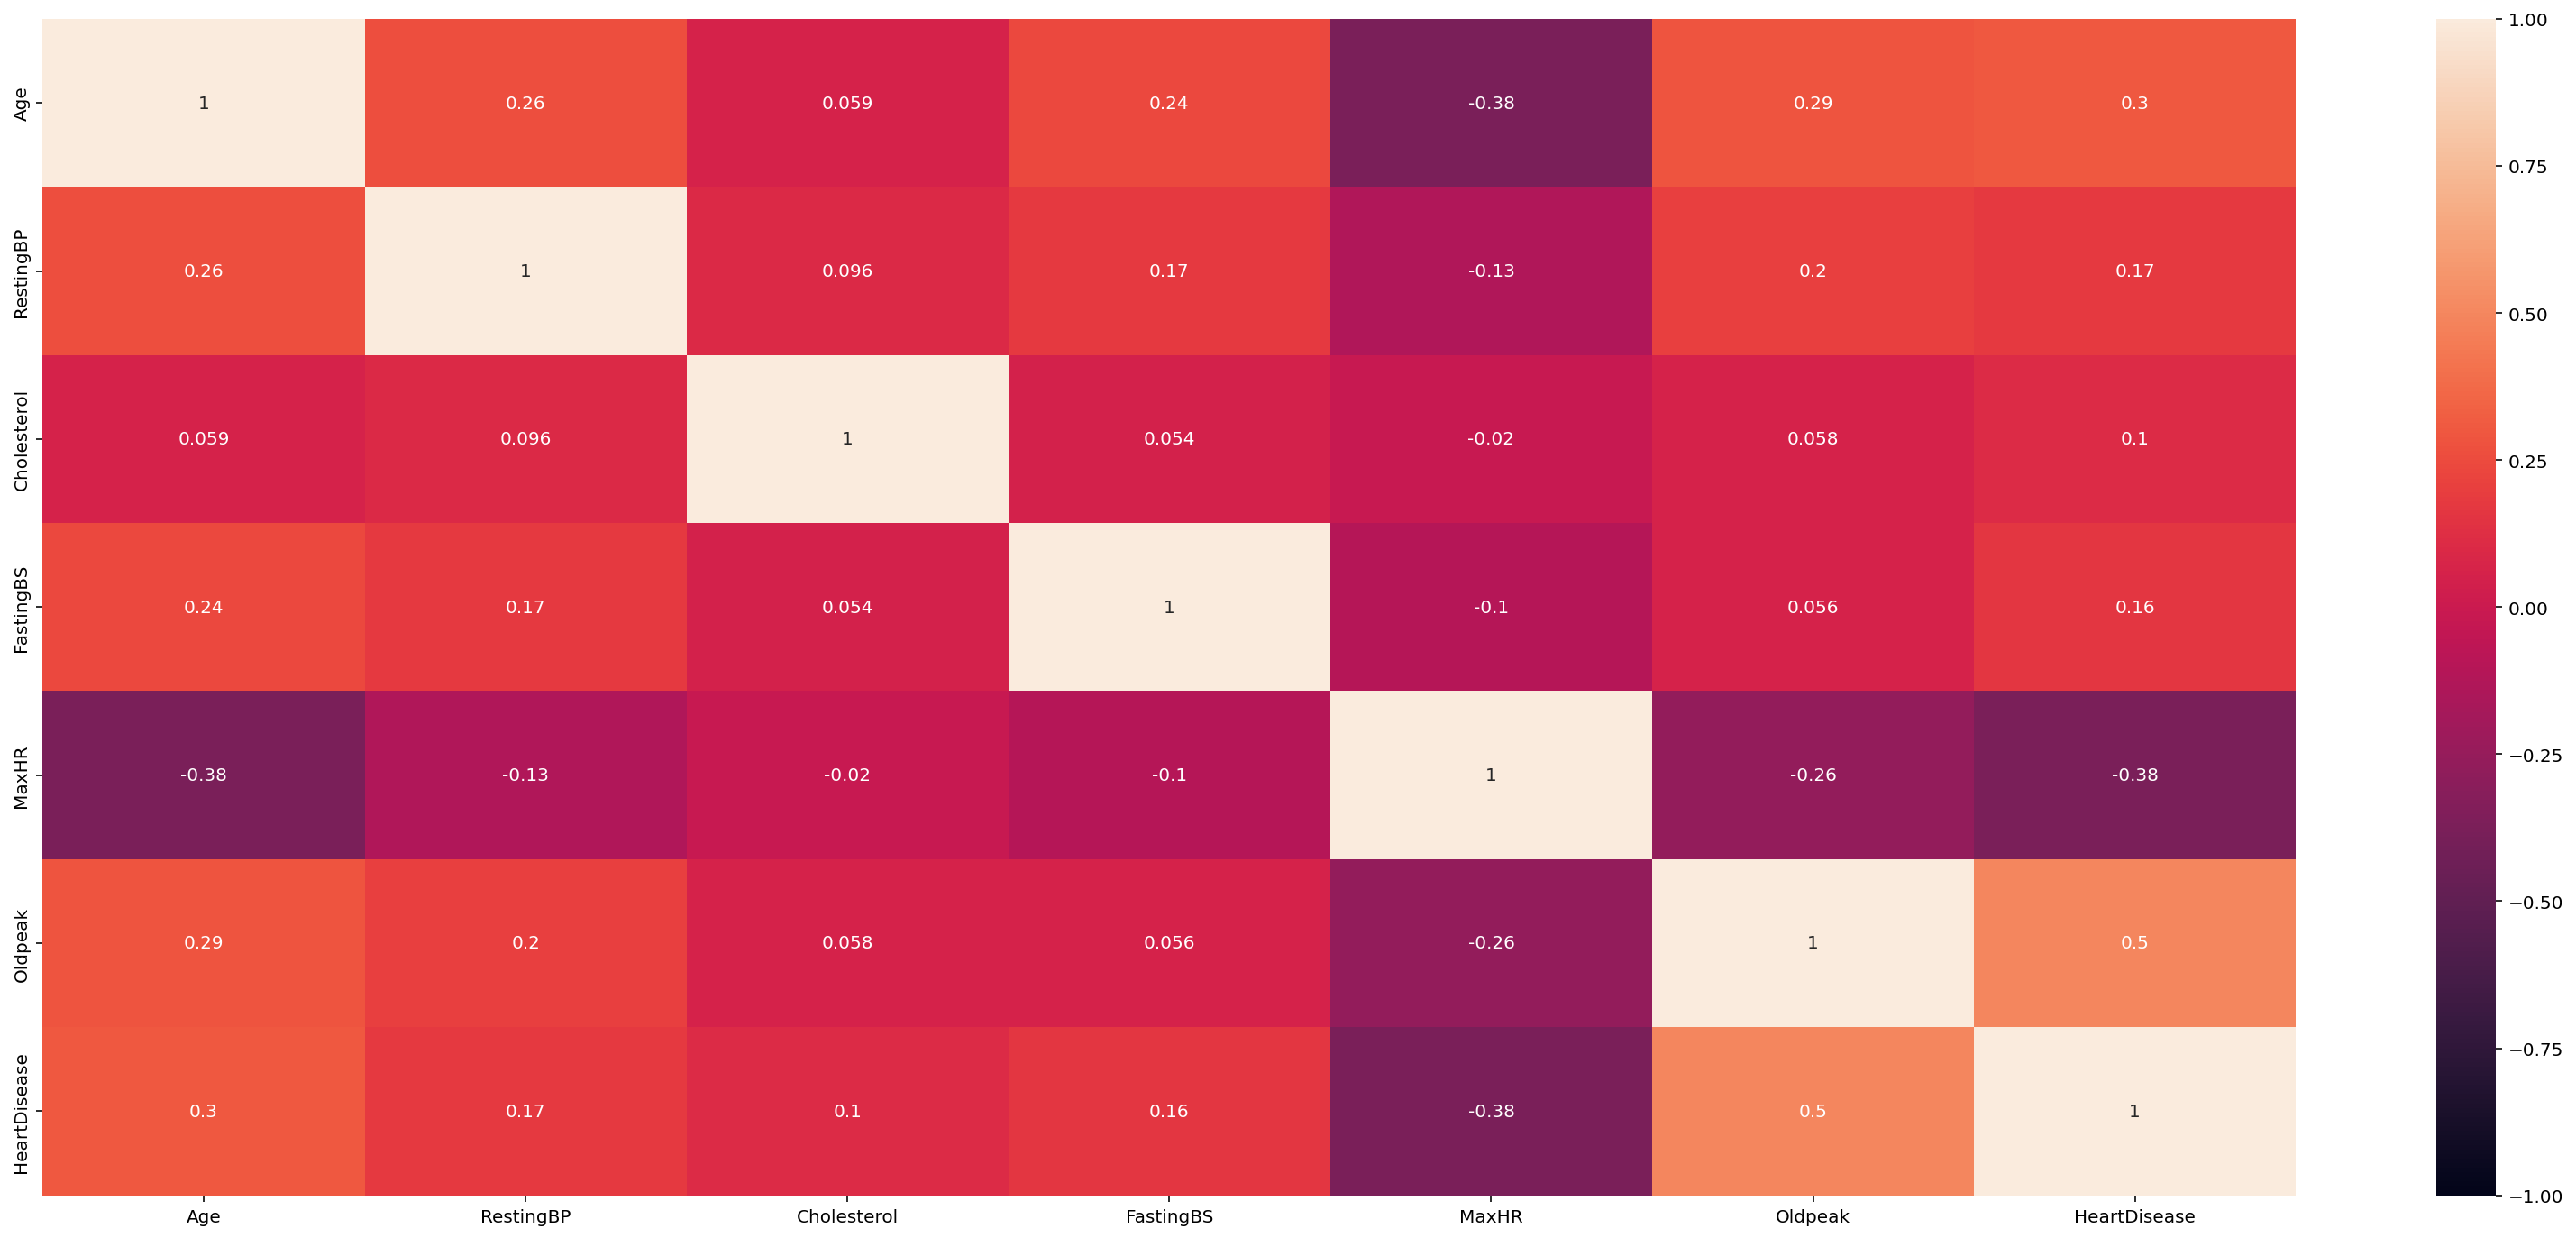

In [17]:
# Plot the correlation matrix
corr = df.corr()
plt.figure(figsize=(28, 12))
sn.heatmap(corr, annot=True, xticklabels=corr.columns, yticklabels=corr.columns, vmin = -1, vmax = 1)
plt.show()

## Pre Processing and Model

### X and y

In [25]:
# Class used to not change some features.
class DoNothing(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X

# Class used to transform categorical features using a one hot encoding and normalize numerical features.
class FeaturesTransformation:
    def __init__(self, categorical_features, numerical_features, other_features=[]):
        self.categorical_features = categorical_features
        self.numerical_features = numerical_features
        self.other_features = other_features

    def pipeline_categories(self):
        return Pipeline([
            ("one_hot", OneHotEncoder())
        ])

    def pipeline_numerical(self):
        return Pipeline([
            ('std_scaler', StandardScaler())
        ])

    def pipeline_pass(self):
        return Pipeline([
            ("nothing", DoNothing())
        ])

    def pipeline(self):
        return ColumnTransformer([
            ("categories", self.pipeline_categories(), self.categorical_features),
            ("numerical", self.pipeline_numerical(), self.numerical_features),
            ("pass", self.pipeline_pass(), self.other_features),
        ])

In [26]:
# List the category of each feature
cat_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

num_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

other_features = ['FastingBS']

feature_pipeline = FeaturesTransformation(cat_features, num_features, other_features)

In [28]:
# Transform the values using the previous class
X = feature_pipeline.pipeline().fit_transform(df)

In [30]:
X.shape

(728, 20)

In [31]:
y = df.HeartDisease.values

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

### Models

#### KNN

In [89]:
from sklearn.neighbors import KNeighborsClassifier

train_accuracies = {}
test_accuracies = {}
neighbors = np.arange(1, 50)
for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train, y_train)
    train_accuracies[neighbor] = knn.score(X_train, y_train)
    test_accuracies[neighbor] = knn.score(X_test, y_test)

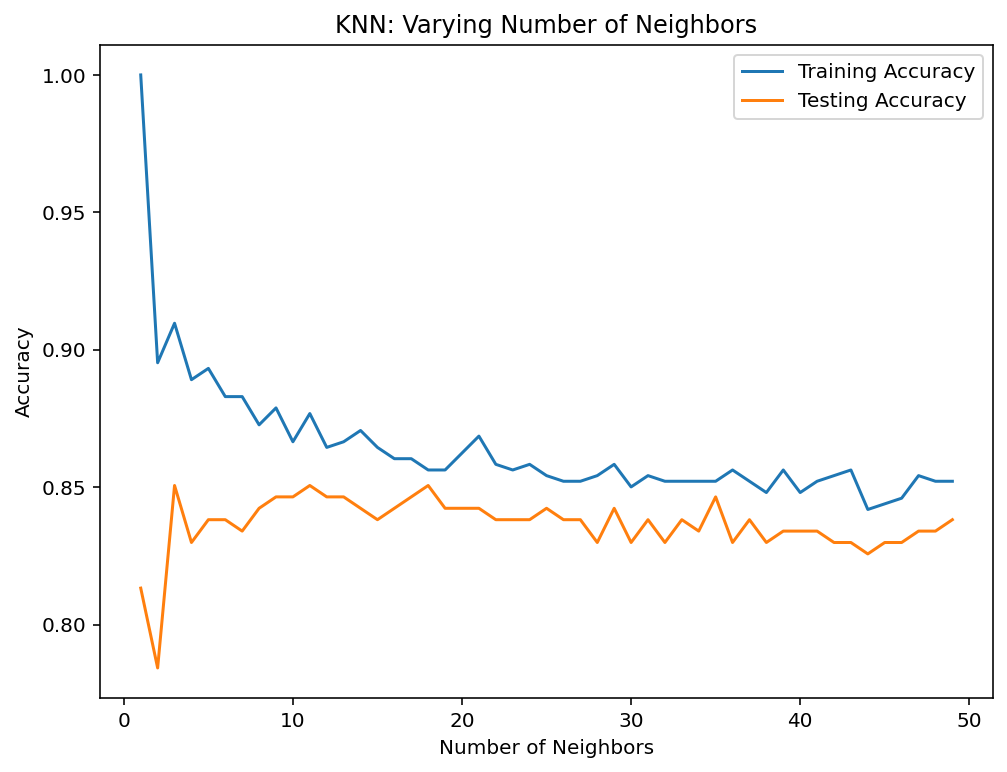

In [90]:
plt.figure(figsize=(8, 6))
plt.title("KNN: Varying Number of Neighbors")
plt.plot(neighbors, train_accuracies.values(), label="Training Accuracy")
plt.plot(neighbors, test_accuracies.values(), label="Testing Accuracy")
plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

In [91]:
print(max(test_accuracies, key=test_accuracies.get))

3


In [92]:
knn.score(X_test, y_test)

0.8381742738589212

In [103]:
knn = KNeighborsClassifier(n_neighbors=18)

knn.fit(X_train, y_train)

train_accuracy = knn.score(X_train, y_train)
test_accuracy = knn.score(X_test, y_test)

print('=======================================')
print('KNN Model results with n_neighbors=18')
print('=======================================\n')

print(f'Train accuracy: {train_accuracy * 100}%')
print(f'Test  accuracy: {test_accuracy * 100}%')

KNN Model results with n_neighbors=18

Train accuracy: 85.62628336755647%
Test  accuracy: 85.06224066390041%


In [104]:
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       128
           1       0.88      0.79      0.83       113

    accuracy                           0.85       241
   macro avg       0.85      0.85      0.85       241
weighted avg       0.85      0.85      0.85       241

[[116  12]
 [ 24  89]]


In [105]:
from sklearn.neighbors import KNeighborsClassifier

train_accuracies = {}
test_accuracies = {}
neighbors = np.arange(1, 50)
for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor, p=1,weights='distance')
    knn.fit(X_train, y_train)
    train_accuracies[neighbor] = knn.score(X_train, y_train)
    test_accuracies[neighbor] = knn.score(X_test, y_test)

knn = KNeighborsClassifier(n_neighbors=max(test_accuracies, key=test_accuracies.get), p=1,weights='distance')

knn.fit(X_train, y_train)

train_accuracy = knn.score(X_train, y_train)
test_accuracy = knn.score(X_test, y_test)

print('=======================================')
print(f'KNN Model results with n_neighbors={max(test_accuracies, key=test_accuracies.get)}')
print('=======================================\n')

print(f'Train accuracy: {train_accuracy * 100}%')
print(f'Test  accuracy: {test_accuracy * 100}%')
y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


KNN Model results with n_neighbors=10

Train accuracy: 100.0%
Test  accuracy: 88.38174273858921%
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       128
           1       0.89      0.86      0.87       113

    accuracy                           0.88       241
   macro avg       0.88      0.88      0.88       241
weighted avg       0.88      0.88      0.88       241

[[116  12]
 [ 16  97]]


[[115  13]
 [ 19  94]]


#### Logistic Regression

In [107]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
c_vals = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = [
    {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'penalty':['l2'], 'C': c_vals},
    {'solver': ['liblinear', 'saga'], 'penalty':['l1', 'l2'], 'C':c_vals},
    {'solver': ['saga'], 'penalty':['elasticnet'], 'C': c_vals, 'l1_ratio': [0.001, 0.01, 0.1, 1]},
]


logreg = LogisticRegression(max_iter=10000)

logreg_cv = GridSearchCV(logreg, param_grid, scoring='accuracy', cv=kf)
logreg_cv.fit(X_train, y_train)

print(logreg_cv.best_params_, logreg_cv.best_score_)


{'C': 0.1, 'l1_ratio': 0.001, 'penalty': 'elasticnet', 'solver': 'saga'} 0.8458868083315799


In [31]:
train_accuracy = logreg_cv.score(X_train, y_train)
test_accuracy = logreg_cv.score(X_test, y_test)

print('=======================================')
print('Logistic Regression Model results with')
print('GridSearchCV params')
print('=======================================\n')

print(f'Train accuracy: {train_accuracy * 100}%')
print(f'Test  accuracy: {test_accuracy * 100}%')

Logistic Regression Model results with
GridSearchCV params

Train accuracy: 85.83162217659137%
Test  accuracy: 87.13692946058092%


In [32]:
y_pred = logreg_cv.predict(X_test)
y_pred_probs = logreg_cv.predict_proba(X_test)[:, 1]
print(y_pred_probs[0])

0.9510250254448874


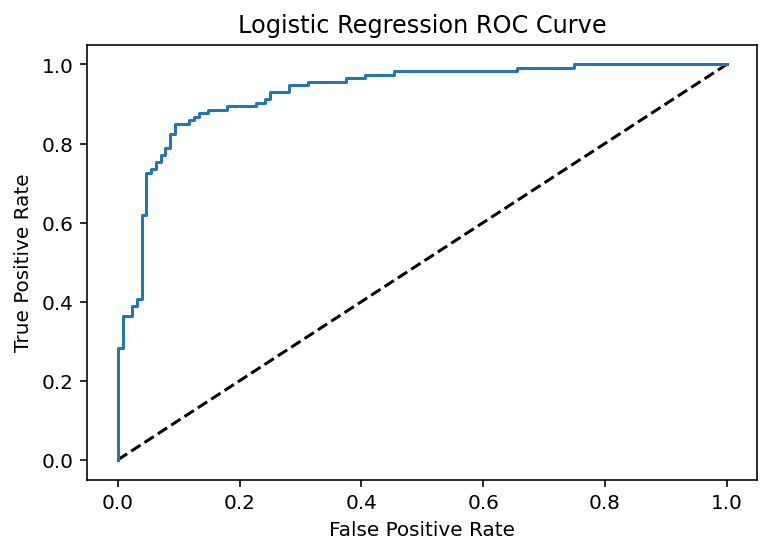

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [34]:
roc_auc_score(y_test, y_pred_probs)

0.9292726769911505

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       128
           1       0.89      0.82      0.86       113

    accuracy                           0.87       241
   macro avg       0.87      0.87      0.87       241
weighted avg       0.87      0.87      0.87       241



In [36]:
print(confusion_matrix(y_test, y_pred))

[[117  11]
 [ 20  93]]


#### gaussian process


/home/morpheus/.local/lib/python3.9/site-packages/sklearn/gaussian_process/_gpc.py:451: RuntimeWarning: overflow encountered in exp
  - np.log1p(np.exp(-(self.y_train_ * 2 - 1) * f)).sum()


0.8630705394190872
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       128
           1       0.83      0.89      0.86       113

    accuracy                           0.86       241
   macro avg       0.86      0.86      0.86       241
weighted avg       0.87      0.86      0.86       241



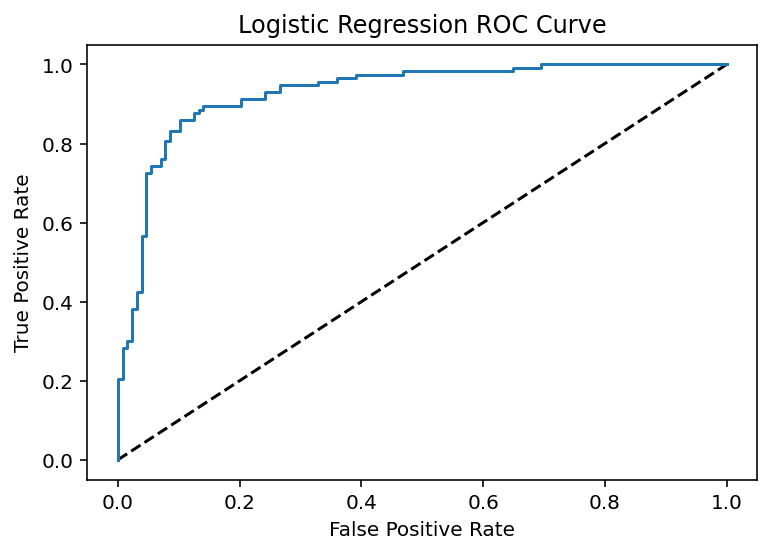

In [129]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

gauss = GaussianProcessClassifier(60.0 * RBF(1.5),n_restarts_optimizer=5,max_iter_predict=1000, warm_start = True)
gauss.fit(X_train,y_train)
scores = gauss.score(X_test,y_test)
print(scores)
#0.8630705394190872
y_pred = gauss.predict(X_test)
print(classification_report(y_test, y_pred))


y_pred_probs = gauss.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

0.8630705394190872
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       128
           1       0.86      0.84      0.85       113

    accuracy                           0.86       241
   macro avg       0.86      0.86      0.86       241
weighted avg       0.86      0.86      0.86       241



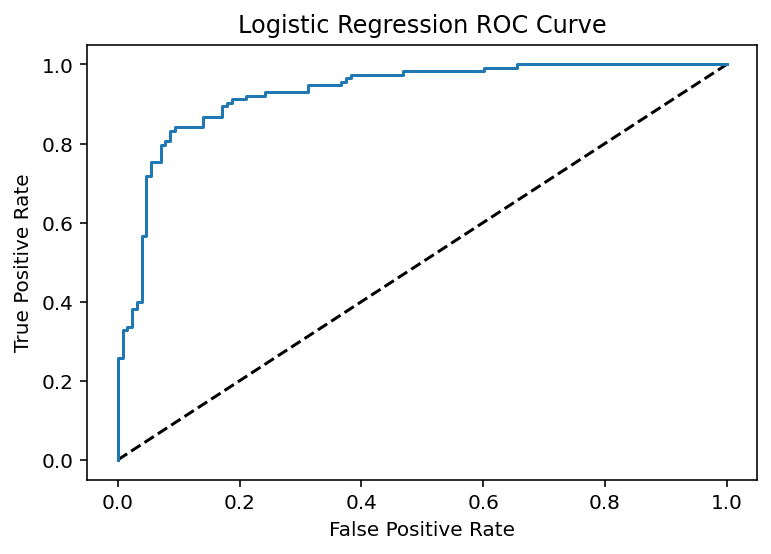

In [131]:
from sklearn.svm import SVC
svc = SVC(gamma='auto', kernel='sigmoid',C=1, probability=True)
svc.fit(X_train,y_train)
scores = svc.score(X_test,y_test)
print(scores)
#0.8630705394190872
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))

y_pred_probs = svc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

0.8298755186721992
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       128
           1       0.84      0.79      0.81       113

    accuracy                           0.83       241
   macro avg       0.83      0.83      0.83       241
weighted avg       0.83      0.83      0.83       241



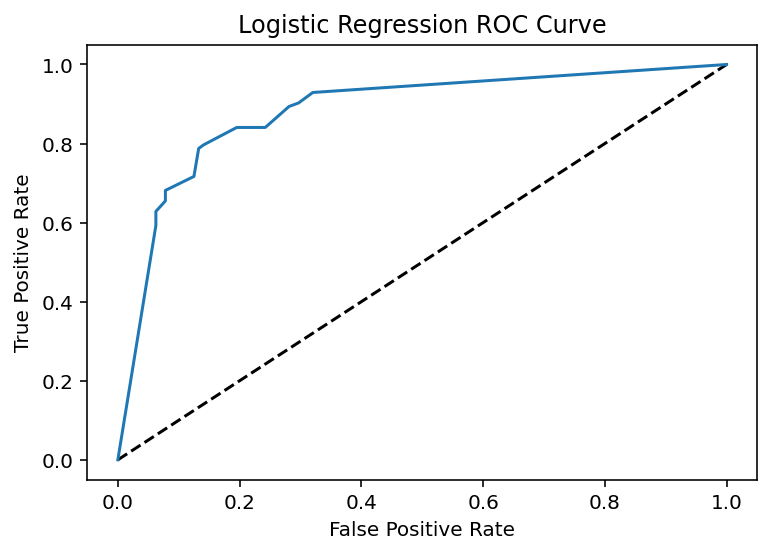

In [189]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=1000, min_samples_leaf = 3, max_features='log2')
dtc.fit(X_train,y_train)
scores = dtc.score(X_test,y_test)
print(scores)
#0.8630705394190872
y_pred = dtc.predict(X_test)
print(classification_report(y_test, y_pred))

y_pred_probs = dtc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

0.8713692946058091
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       128
           1       0.89      0.83      0.86       113

    accuracy                           0.87       241
   macro avg       0.87      0.87      0.87       241
weighted avg       0.87      0.87      0.87       241



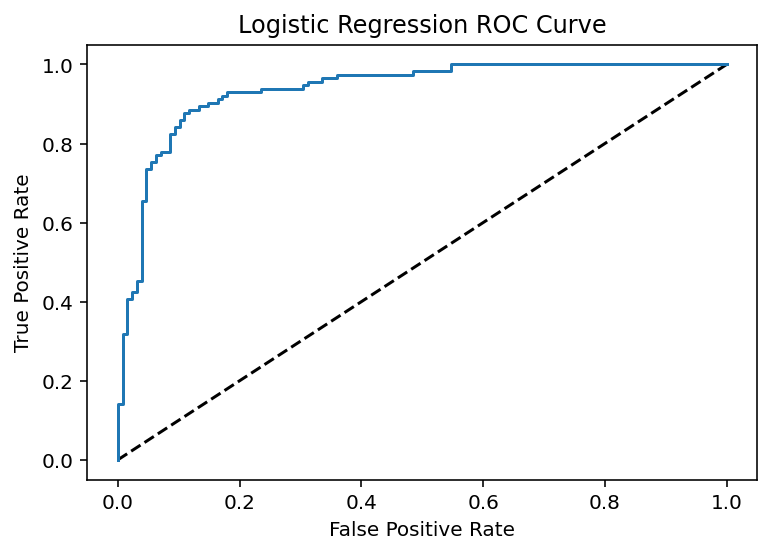

In [190]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(alpha=1, max_iter=1000)
mlp.fit(X_train,y_train)
scores = mlp.score(X_test,y_test)
print(scores)
#0.8630705394190872
y_pred = mlp.predict(X_test)
print(classification_report(y_test, y_pred))

y_pred_probs = mlp.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()